# EEG WORKSHOP PRE-PROCESSING

## 1. Reading in the Data

In [1]:
# importing modules
import os
import numpy as np
import mne

In [2]:
# reading the data in
raw = mne.io.read_raw_brainvision("58044/FaceWord_Group5.vhdr", eog=('EOG1', 'EOG2'))
raw.load_data()

raw

Extracting parameters from 58044/FaceWord_Group5.vhdr...
Setting channel info structure...
Reading 0 ... 374439  =      0.000 ...   374.439 secs...


<RawBrainVision | FaceWord_Group5.eeg, 32 x 374440 (374.4 s), ~91.5 MB, data loaded>

Looking at the output from the read function, we see that we have 6.14 minutes of data as expected. However, we know for a fact that one of the channels is a bad channel (Cz). 

In [3]:
# specyfing the channel location using the montage related functions
montage = mne.channels.make_standard_montage('standard_1020')

raw.set_montage(montage, verbose=False)

<RawBrainVision | FaceWord_Group5.eeg, 32 x 374440 (374.4 s), ~91.5 MB, data loaded>

From the output, we have 33 digitised points. We have 32 electrodes, and we guess that the last point is a reference electrode 

In [4]:
#redefining reference to a common average
raw.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | FaceWord_Group5.eeg, 32 x 374440 (374.4 s), ~91.5 MB, data loaded>

## 2. PLOTTING and Filtering !! 

Using matplotlib as 2D backend.
Opening raw-browser...


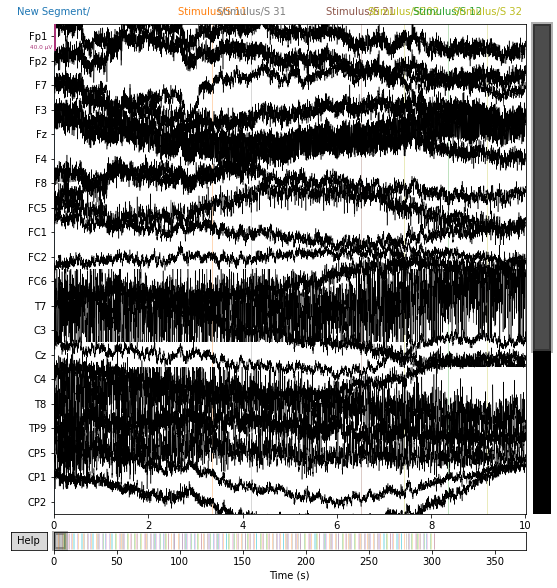

In [5]:
# default plot function
raw.pick_types(meg=False, eeg=True, stim=True)
raw.plot();

Opening raw-browser...


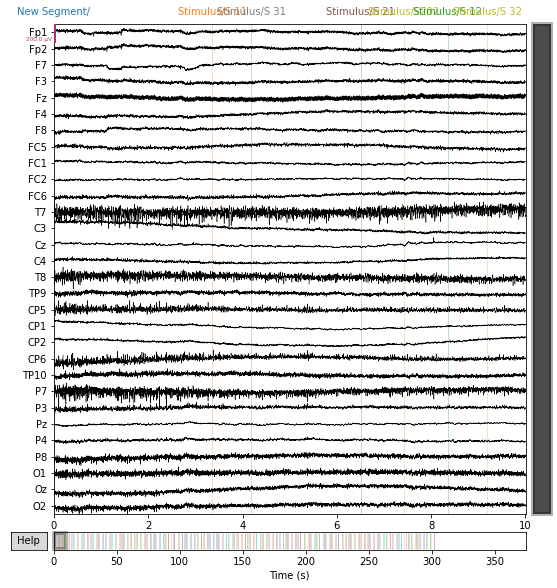

In [6]:
# choosing all channels and scaling (set to auto for now) 
raw.pick_types(meg=False, eeg=True, stim=True)
raw.plot(n_channels = 32, scalings = dict(eeg=100e-6, eog=150e-6));

### 2.1 FILTERING

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 sec)

Opening raw-browser...


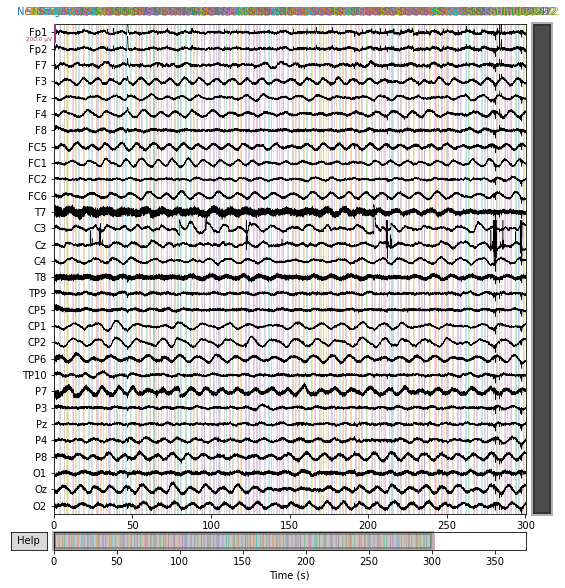

In [7]:
raw = raw.filter(0.1, 40) #high-pass filtering at 0.1 Hz, and low-pass filtering at 40 hZ. 

raw.plot(n_channels = 32, scalings = dict(eeg=100e-6, eog=150e-6), duration = 300); #defining duration at 300 to get a better idea of the bad channels

After having both scaled and filtered the data, we note that filtering got rid of a lot of noise. We decide to exclude the channels: T7, T8. 

### 2.2 Excluding channels

Opening raw-browser...


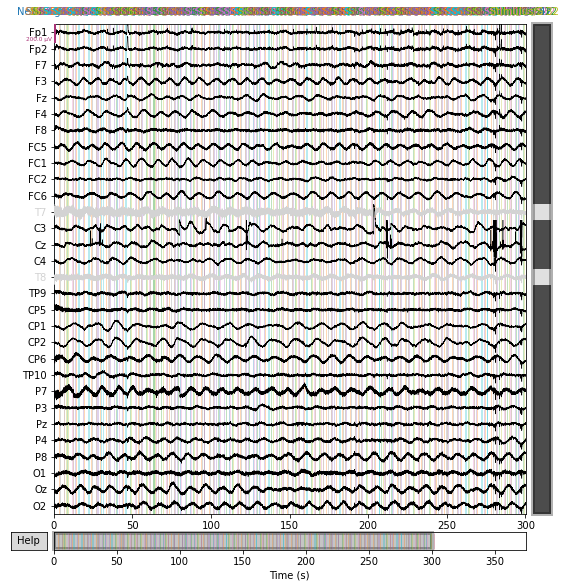

In [8]:
# Defining bad channels 
raw.info['bads'] = ['T7', 'T8']
raw.plot(n_channels = 32, scalings = dict(eeg=100e-6, eog=150e-6), duration = 300.0);

Opening raw-browser...


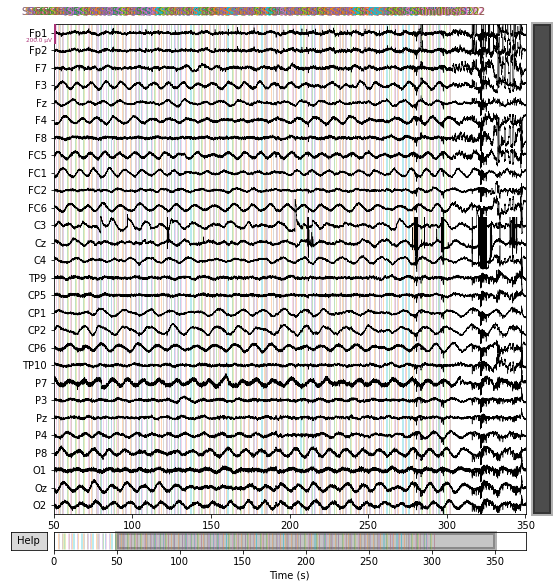

In [9]:
# excluding bad channels  
raw.pick_types(meg=False, eeg=True, stim=True, exclude='bads')
raw.plot(n_channels = 32, scalings = dict(eeg=100e-6, eog=150e-6), start = 50, duration = 300.0);

### 2.3 EPOCHS 

In [10]:
# extracting the triggers
info = mne.events_from_annotations(raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S101', 'Stimulus/S102', 'Stimulus/S112', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S212']


In [11]:
# extracting unique values
info[1]

# finding all events 
events = info[0]

In [12]:
# setting up event dictionary 
event_id = {'Word/wPos': 11, # positive word
            'Wait/wPos': 31, # waiting time after positive word 
            'Image/wPos': 21, # positive image (always following pos word) 
            'Word/wNeg': 12, # negative word 
            'Wait/wNeg': 32, # waiting time after negative word 
            'Image/wNeg': 22, # negative image (always following neg word) 
            'Word/wNeu': 13, # neutral word 
            'Wait/wNeu/iPos': 51, # wait time after neu w (before pos i) 
            'Image/wNeu/iPos': 41, # positive image (after neu word) 
            'Wait/wNeu/iNeg': 52, # wait time after neu w (before neg i) 
            'Image/wNeu/iNeg': 42, # negative image (after neu word) 
            'Correct/wPos': 101, # correct response ('b') to pos w + image 
            'Correct/wNeg': 102, # correct response ('y') to neg w + image 
            #'Correct/wNeu/iPos': 111, # cor resp ('b') to neu w + pos image 
            'Correct/wNeu/iNeg': 112, # cor resp ('y') to neu w + neg image 
            'Incorrect/wPos': 202, # incor resp ('y') to pos w + image 
            'Incorrect/wNeg': 201, # incor resp ('b') to neg w + image 
            'Incorrect/wNeu/iPos': 212, # incor resp ('y') to neu w + pos i 
            #'Incorrect/Neu/iNeg': 211, # incor resp ('b') to neu w + neg i 
           }

/tmp/ipykernel_401/2862750187.py:2: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);
/tmp/ipykernel_401/2862750187.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);


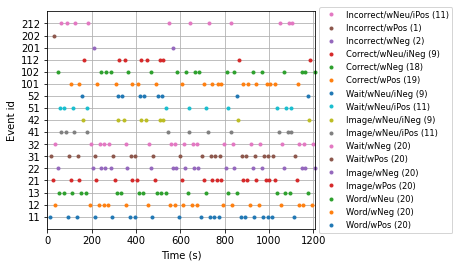

In [13]:
# plotting the events 
mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);

The plot seems sensible. There are fewer incorrect events than correct ones. There are more incorrect responses with neutral words that are followed by a positive smiley. 

In [14]:
# setting time window 
tmin, tmax = -0.1, 0.7

# choosing only EEG channels for epoching (thus EOG false) 
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False)

#reject criterion of 150 microvolts
reject = dict(eeg=150e-6)

# epochsss 
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
240 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 240 events and 801 original time points ...
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['C3']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1']
12 bad epochs dropped


12 bad epochs are dropped. Only 5 % of the total epochs (240) are dropped, so we do not adjust the rejection criterion. 

### 2.4 Downsampling 

In [15]:
#downsampling hz
epochs_resampled = epochs.resample(250) #instead of having 801 timepoints, we downsample to 250 time points per second. 

### 2.5 Consistency Plot

In [18]:
word_epochs = epochs_resampled['Word']
img_epochs = epochs_resampled['Image']

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


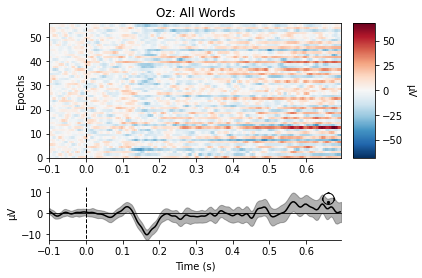

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


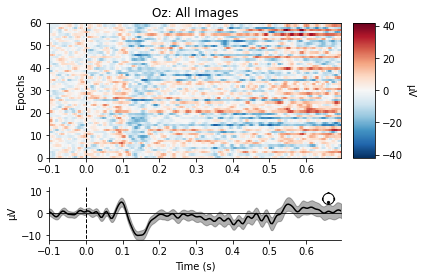

In [26]:
# plotting one channel as an example for all words and all images, seperately
all_words = word_epochs.plot_image(picks=['Oz'], title = "Oz: All Words");

#all_words[0].savefig(fname = "all_words_plot")


all_imgs = img_epochs.plot_image(picks=['Oz'], title = "Oz: All Images");
all_imgs[0].savefig(fname = "all_imgs_plot")

# Creating Evoked Variables

In [30]:
word_pos_epochs = epochs_resampled['Word/wPos']
word_neg_epochs = epochs_resampled['Word/wNeg']
word_neu_epochs = epochs_resampled['Word/wNeu']

word_pos_evoked = word_pos_epochs.average()
word_neg_evoked = word_neg_epochs.average()
word_neu_evoked = word_neu_epochs.average()

No projector specified for this dataset. Please consider the method self.add_proj.


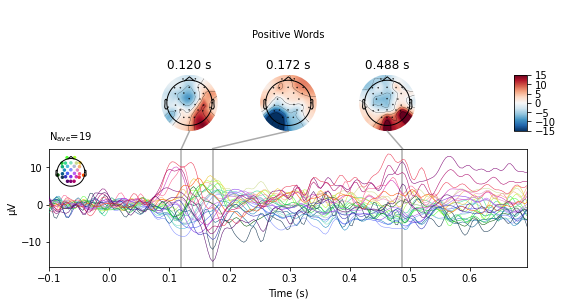

No projector specified for this dataset. Please consider the method self.add_proj.


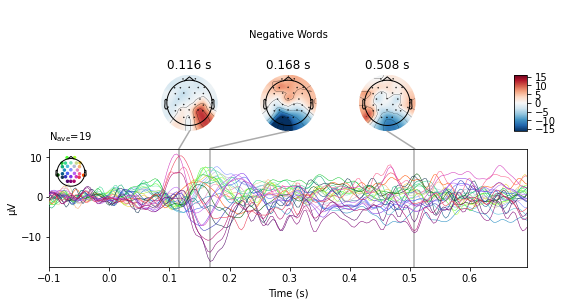

No projector specified for this dataset. Please consider the method self.add_proj.


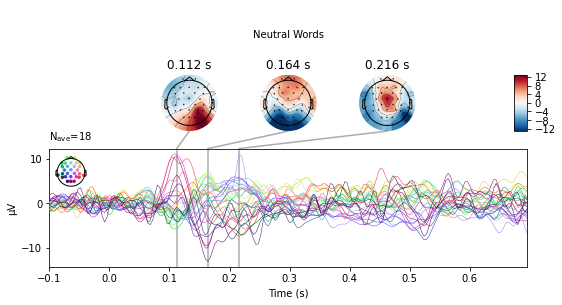

In [36]:
#categorising
word_pos_plot = word_pos_evoked.plot_joint(picks='eeg', title = "Positive Words");
word_pos_plot.savefig(fname = "word_pos_plot")

word_neg_plot = word_neg_evoked.plot_joint(picks='eeg', title = "Negative Words");
word_neg_plot.savefig(fname = "word_neg_plot")

word_neu_plot = word_neu_evoked.plot_joint(picks='eeg', title = "Neutral Words");
word_neu_plot.savefig(fname = "word_neu_plot")

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


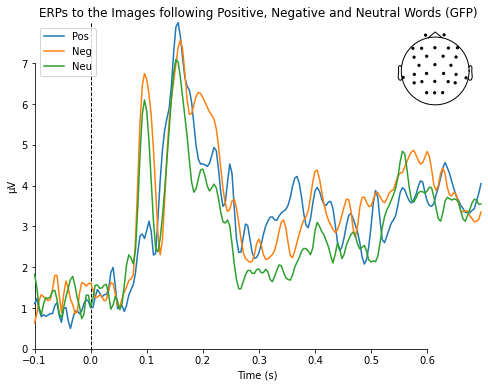

In [56]:
#Comparing evoked for images
img_pos_epochs = epochs_resampled['Image/wPos']
img_neg_epochs = epochs_resampled['Image/wNeg']
img_neu_epochs = epochs_resampled['Image/wNeu/iPos','Image/wNeu/iNeg']


img_pos_evoked = img_pos_epochs.average()
img_neg_evoked = img_neg_epochs.average()
img_neu_evoked = img_neu_epochs.average()

comparison_plot = mne.viz.plot_compare_evokeds({'Pos':img_pos_evoked, 'Neg':img_neg_evoked, 'Neu':img_neu_evoked},
                             legend='upper left', show_sensors='upper right', title = "ERPs to the Images following Positive, Negative and Neutral Words")

comparison_plot[0].savefig(fname = "comparison_plot")


combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


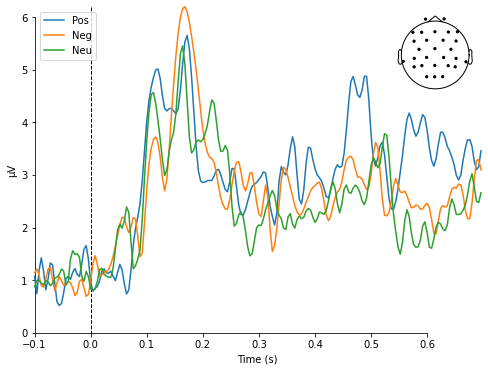

[<Figure size 576x432 with 2 Axes>]

In [51]:
mne.viz.plot_compare_evokeds({'Pos':word_pos_evoked, 'Neg':word_neg_evoked, 'Neu':word_neu_evoked},
                             legend='upper left', show_sensors='upper right')
